# Contents

* 1.Loading the IMDB Dataset
* 2.Preparing the data
* 3.Building our Network
    * 3.1 The model definition
    * 3.2 Compiling the model
    * 3.3 Validating our approach
    * 3.4 Training the model
    * 3.5 Plotting the training and the validation loss
    * 3.6 Plotting the training and the validation accuracy
    * 3.7 Retraining a model from scratch
* 4.Further Experiments
* 5.Wrapping up
    

* This little project is to use deep learning to classify  Movie reviews in the Internet Movie DataBase (IMDB) as negative or positive. 
 
* The IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

# 1.Loading the IMDB Dataset

In [1]:
import tensorflow as tf
import keras

/home/kevindegila/.conda/envs/mytensor/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.datasets import imdb

In [3]:
(train_data, train_labels),(test_data, test_labels) = imdb.load_data(num_words=10000)

The argument **num_words=10000** means we’ll only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.

The variables **train_data and test_data** are lists of reviews; each review is a list of
word indices (encoding a sequence of words). **train_labels and test_labels** are
lists of 0s and 1s, where 0 stands for negative and 1 stands for positive:

In [4]:
len(train_data[0]), len(train_data[15000])

(218, 281)

In [5]:
train_labels[0], train_labels[15000]

(1, 0)

Because we’re restricting yourself to the top 10,000 most frequent words, no word
index will exceed 10

In [6]:
max([max(sequence) for sequence in train_data])

9999

Let's decode one of the reviews:

In [7]:
#word_index is a dictionary mapping word to an integer index
word_index = imdb.get_word_index()
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [8]:
#Let's reverse the dictionary
reverse_word_index = dict(
    [(value, key) for (key,value) in word_index.items()])

Here are the top 5 frequent words in the reviews. the key or index start at 1

In [9]:
reverse_word_index[1],reverse_word_index[2], reverse_word_index[3],reverse_word_index[4],reverse_word_index[5]

('the', 'and', 'a', 'of', 'to')

In [10]:
decoded_review = ' '.join([reverse_word_index.get(i-3,'?') for i in train_data[0]])

#train_data[0] is a list of indexes. Normally a 585 in the list correspond to a word we can get with
#reverse_word_index[585] but in this case it'll be reverse_word_index[585 - 3] because 0, 1, and 2 are
#reserved indices for “padding,” “start of
#sequence,” and “unknown.” If a key is not in our dictionary, we'll return '?'. Then we join all the corresponding
#words is the list by separating them by an espace to make it clear to read. However we must be aware that words
#which are not frequent(top 10000) in our dataset are removed so few words might be missing and we'll have to 
#guess them. It should be intuitive

In [11]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

# 2.Preparing the data

We can’t feed lists of integers into a neural network. We have to turn our lists into
tensors. There are two ways to do that:
* Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use as the first layer in your network a layer capable of handling such integer tensors

* One-hot encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then we could use as the first layer in your network a Dense layer, capable of handling floating-point vector data.

Let’s go with the latter solution to vectorize the data, which we’ll do manually for
maximum clarity.

In [12]:
import numpy as np

In [13]:
def vectorized_sequences(sequences, dimension = 10000):
    #Creating an all-zero matrix of shape (len(sequences),dimension)
    results = np.zeros((len(sequences),dimension))
    
    for i, sequence in enumerate(sequences):
        results[i,sequence] = 1
    return results

In [14]:
x_train = vectorized_sequences(train_data)
x_test = vectorized_sequences(test_data)

In [23]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize your labels, which is straightforward:

In [16]:
train_labels

array([1, 0, 0, ..., 0, 1, 0])

In [17]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [18]:
y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

Now our data is ready to be fed to a neural network

# 3.Building our Network

## 3.1 The model definition

In [24]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## 3.2 Compiling the model

In [25]:
model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['acc'])

## 3.3 Validating our approach

In [26]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

In [27]:
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## 3.4 Training the model

In [28]:
history = model.fit(partial_x_train,partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 226us/step - loss: 0.5082 - acc: 0.7816 - val_loss: 0.3795 - val_acc: 0.8686
Epoch 2/20
15000/15000 [==============================] - 2s 131us/step - loss: 0.3002 - acc: 0.9047 - val_loss: 0.3001 - val_acc: 0.8900
Epoch 3/20
15000/15000 [==============================] - 2s 130us/step - loss: 0.2178 - acc: 0.9281 - val_loss: 0.3080 - val_acc: 0.8718
Epoch 4/20
15000/15000 [==============================] - 2s 131us/step - loss: 0.1750 - acc: 0.9436 - val_loss: 0.2840 - val_acc: 0.8836
Epoch 5/20
15000/15000 [==============================] - 2s 130us/step - loss: 0.1426 - acc: 0.9544 - val_loss: 0.2850 - val_acc: 0.8868
Epoch 6/20
15000/15000 [==============================] - 2s 130us/step - loss: 0.1149 - acc: 0.9649 - val_loss: 0.3129 - val_acc: 0.8782
Epoch 7/20
15000/15000 [==============================] - 2s 134us/step - loss: 0.0977 - acc: 0.9711 - val_loss: 0.3130 - 

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

## 3.5 Plotting the training and the validation loss

In [30]:
%matplotlib inline

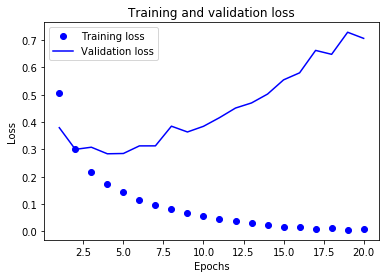

In [35]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') #bo is for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') #b is for solid blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3.6 Plotting the training and the validation accuracy

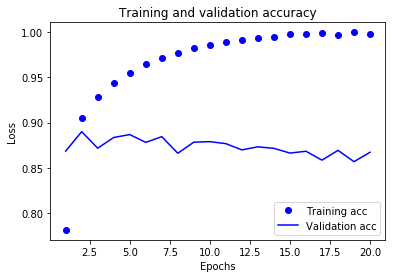

In [38]:
plt.clf() #clear the figures
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can notice that after 5 epochs our validation accuracy start to decrease considerably, while the training accuracy keeps increasing. This is an example of overfitting. One way to avoid this is to reduce the number of epochs to 4. Let's train a new network from scratch using only 4 epochs

## 3.7 Retraining a model from scratch

In [39]:
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size = 512)

results = model.evaluate(x_test,y_test)

Epoch 1/4
25000/25000 [==============================] - 3s 115us/step - loss: 0.4749 - acc: 0.8214
Epoch 2/4
25000/25000 [==============================] - 2s 91us/step - loss: 0.2652 - acc: 0.9100
Epoch 3/4
25000/25000 [==============================] - 2s 91us/step - loss: 0.1984 - acc: 0.9303
Epoch 4/4
25000/25000 [==============================] - 2s 76us/step


In [40]:
results

[0.32343911949157717, 0.87276]

This fairly naive approach achieves an accuracy of 88%. With state-of-the-art
approaches, we should be able to get close to 95%

# 4.Further Experiments

The following experiments will help ensure  that the architecture choices we’ve
made are all fairly reasonable, although there’s still room for improvement:

**Let's used 3 hidden layers instead of 2 and see how
doing so affects validation and test accuracy.**

In [42]:
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(16, activation = 'relu')) #3rd hidden layers
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size = 512)

results = model.evaluate(x_test,y_test)

Epoch 1/4
25000/25000 [==============================] - 3s 103us/step - loss: 0.4557 - acc: 0.8121
Epoch 2/4
25000/25000 [==============================] - 2s 94us/step - loss: 0.2542 - acc: 0.9095
Epoch 3/4
25000/25000 [==============================] - 2s 93us/step - loss: 0.1945 - acc: 0.9306
Epoch 4/4
25000/25000 [==============================] - 2s 78us/step


In [43]:
results

[0.3009793103694916, 0.88284]

Actually using 3 hidden layers improved our model accuracy, and decrease the loss. This architecture is better than the one we used. At this point, i don't know how to choose the number of hidden layers and the nomber of hidden units in each layer

**Using layers with more hidden units : 32 units**

In [44]:
model = models.Sequential()
model.add(layers.Dense(32, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu')) #3rd hidden layers
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size = 512)

results = model.evaluate(x_test,y_test)

Epoch 1/4
25000/25000 [==============================] - 3s 114us/step - loss: 0.4417 - acc: 0.8132
Epoch 2/4
25000/25000 [==============================] - 3s 104us/step - loss: 0.2416 - acc: 0.9095
Epoch 3/4
25000/25000 [==============================] - 3s 101us/step - loss: 0.1886 - acc: 0.9307
Epoch 4/4
25000/25000 [==============================] - 2s 83us/step


In [45]:
results

[0.34794556042671204, 0.87268]

Approximatively the same results as our first architecture.

**Using the mse loss function instead of binary_crossentropy.**

In [46]:
model = models.Sequential()
model.add(layers.Dense(16, activation = 'relu', input_shape = (10000,)))
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(16, activation = 'relu')) #3rd hidden layers
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop',
             loss = 'mse',
             metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size = 512)

results = model.evaluate(x_test,y_test)

Epoch 1/4
25000/25000 [==============================] - 3s 103us/step - loss: 0.1698 - acc: 0.7994
Epoch 2/4
25000/25000 [==============================] - 2s 92us/step - loss: 0.0817 - acc: 0.9074
Epoch 3/4
25000/25000 [==============================] - 2s 92us/step - loss: 0.0584 - acc: 0.9300
Epoch 4/4
25000/25000 [==============================] - 2s 74us/step


In [47]:
results

[0.08591119261503219, 0.88532]

This is our best accuracy so far

**Using the tanh activation (an activation that was popular in the early days of
neural networks) instead of relu**

In [48]:
model = models.Sequential()
model.add(layers.Dense(16, activation = 'tanh', input_shape = (10000,)))
model.add(layers.Dense(16, activation = 'tanh'))
model.add(layers.Dense(16, activation = 'tanh')) #3rd hidden layers
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer='rmsprop',
             loss = 'mse',
             metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size = 512)

results = model.evaluate(x_test,y_test)

Epoch 1/4
25000/25000 [==============================] - 3s 109us/step - loss: 0.1318 - acc: 0.8219
Epoch 2/4
25000/25000 [==============================] - 2s 92us/step - loss: 0.0653 - acc: 0.9156
Epoch 3/4
25000/25000 [==============================] - 2s 94us/step - loss: 0.0508 - acc: 0.9336
Epoch 4/4
25000/25000 [==============================] - 2s 70us/step


In [49]:
results

[0.09605370857954025, 0.87472]

#  5.Wrapping up

Here’s what we should take away from this project:
* You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it—as tensors—into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options, too.
* Stacks of Dense layers with relu activations can solve a wide range of problems (including sentiment classification), and you’ll likely use them frequently.
* In a binary classification problem (two output classes), your network should end with a Dense layer with one unit and a sigmoid activation: the output of your network should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output on a binary classification problem, the loss function you should use is binary_crossentropy.
* The rmsprop optimizer is generally a good enough choice, whatever your problem. That’s one less thing for you to worry about.
* As they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set